# Classification on `emnist`

## 1. Create `Readme.md` to document your work

Explain your choices, process, and outcomes.

## 2. Classify ~~all symbols~~ letters a -> g

### Subset the data

Select only the lowercase letters (a, b, ..., g) for classification

### Choose a model

Your choice of model! Choose wisely...

### Train away!

Is do you need to tune any parameters? Is the model expecting data in a different format?

### Evaluate the model

Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets

On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

## 3. Model showdown: upper vs lowercase on abcXYZ

### Subset the data

Select out the set of upper- and lowercase (a, b, c, x, y z, A, B, C, X, Y, Z). Note that some of these classes can be confusing (e.g., x and y).

### Train and tune models

Perform a full model training and hyperparameter tuning.

1. Select candidate models, hyperparameter options, and evaluation metric
2. Set aside a validation hold-out dataset
3. Train models over K splits (use k-fold or train/test split)
    1. Split train using k-fold with the number of folds equal to the number of parameter combinations
    2. Train on k-fold split
    3. Record performance of each set of parameters
    4. Use winning set of parameters to train model on full training set
    5. Record each model's performance on that split's test set
4. Evaluate model performance and promote one model as the winner
5. Train winning model on both train + test
6. Check model performance on the validation hold-out


## 4. (_Optional_) Model comparison: classify even vs odd

**NOTE:** This is a larger dataset (~400k rows) so it will require more memory and time to train models on it. 

Alternatively, you can train models on smaller subsets of the data to get a feel for which models perform better than others. Then train the winning model on the full dataset and validate against the hold-out.

### Subset the data

Select only digits and add a column for 'is_even'. Be sure to create a validation hold-out dataset for later.

### Build and compare models

Train at least two different models, compare the results and choose a winner based on an evaluation metric of your choice.

In [1]:
%pip install -q emnist pandas pyarrow numpy matplotlib seaborn scikit-learn xgboost tensorflow
%reset -f


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist
from IPython.display import display, Markdown

# ML packages
from sklearn.model_selection import train_test_split
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28

In [3]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

In [4]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
emnist_train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
emnist_train['image'] = list(image)
emnist_train['image_flat'] = emnist_train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
emnist_train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
emnist_train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
emnist_test = pd.DataFrame()
emnist_test['image'] = list(image)
emnist_test['image_flat'] = emnist_test['image'].apply(lambda x: np.array(x).reshape(-1))
emnist_test['label'] = label
emnist_test['class'] = class_label

# Combine the training and test splits
emnist_all = pd.concat([emnist_train, emnist_test], axis=0)

# Subset for only digits 0-9
digits = emnist_all[emnist_all['label'] < 10]

# Subset for lowercase letters
lowercase = emnist_all[(emnist_all['class'] >= 'a') & (emnist_all['class'] <= 'z')]
uppercase = emnist_all[(emnist_all['class'] >= 'A') & (emnist_all['class'] <= 'Z')]

# Subset for upper- and lowercase letters a, b, c, d, e, f, g
a2g = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'd', 'e', 'f', 'g']))]

# Subset for upper- and lowercase letters a, b, c, x, y, z
abcxyz = emnist_all[(emnist_all['class'].isin(['a', 'b', 'c', 'A', 'B', 'C', \
                                               'x', 'y', 'z', 'X', 'Y', 'Z']))]

In [5]:
# Display the size of a2g, abcxyz, digits, and the full dataset
display(Markdown(f'# Dataset Sizes'))
display(Markdown(f'**a2g**: {len(a2g)}'))
display(Markdown(f'**abcxyz**: {len(abcxyz)}'))
display(Markdown(f'**digits**: {len(digits)}'))
display(Markdown(f'**emnist_all**: {len(emnist_all)}'))

# Dataset Sizes

**a2g**: 68795

**abcxyz**: 65926

**digits**: 402953

**emnist_all**: 814255

In [6]:
# FIXME: Classify lettters as uppercase/lowercase
abcxyz['is_upper'] = ...

# FIXME: Classify digits as even/odd
digits['is_even'] = ...

/var/folders/z6/cdbhmtbd2n133ft_7cpd4wbc0000gn/T/ipykernel_31284/2067495769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abcxyz['is_upper'] = ...
/var/folders/z6/cdbhmtbd2n133ft_7cpd4wbc0000gn/T/ipykernel_31284/2067495769.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  digits['is_even'] = ...


### 2. Classifying a through g using Random Forest

In [10]:
# Test Train Split
X = np.array(a2g['image_flat'].tolist())
y = a2g['label']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Build and train model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)

**Performance**

In [11]:
# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

# Print performance metrics
print(f"Accuracy: {acc}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.9615524384039538
Precision: 0.9616097426229526
Recall: 0.9615524384039538
F1 Score: 0.9610927986291605
Confusion Matrix:
[[2370    4    5   14   36    2   16]
 [   6 1147    2   18    8    7    6]
 [  20    1  532    2   78    0    1]
 [  38   17    2 2262    1    5    3]
 [  28    3   14    6 5656    7    2]
 [   7    3    2    9   12  551    9]
 [  84    2    1   16   22   10  712]]


**Exploring Areas for Improvement**

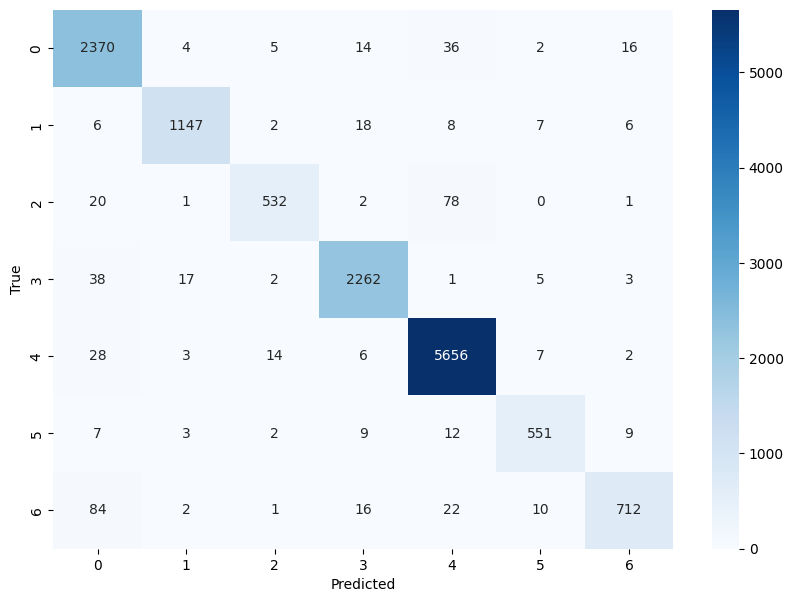

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Label 0 seems to be predicted poorly. True, predicted value of (6,0) seems to also be a common error.

To increase performance, we could perform a grid search for the best max depth, minimum samples for a split/leaf, number of estimators (below). 

Other methods which I will not implement (due to compute time/resources) include additional feature engineering (PCA for dimension reduction) ensemble methods (XGBoost), augmenting the training data (rotating, scaling, flipping data), or applying more complex algorithms like a neural network.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize grid search model
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fithe grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

### 3. Classifying abc vs. XYZ using Logistic Regression and Random Forest

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np

# Otherwise takes way too long to run. Emily/Professor you can change frac to 1.0 if you want the full dataset.
abcxyz_sampled = abcxyz.sample(frac=0.01, random_state=42)

X = np.array(abcxyz_sampled['image_flat'].tolist())
y = np.array(abcxyz_sampled['class'])

X_train_val, X_test_holdout, y_train_val, y_test_holdout = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Define the parameter grid 
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear']}
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}

# Logistic Regression Grid Search
lr_grid_search = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train_val, y_train_val)

# Random Forest Grid Search
rf_grid_search = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [22]:
print("Best Logistic Regression Score:", lr_grid_search.best_score_)
print("Best Random Forest Score:", rf_grid_search.best_score_)

# Select winner
winner_model = lr_grid_search if lr_grid_search.best_score_ > rf_grid_search.best_score_ else rf_grid_search

Best Logistic Regression Score: 0.6338005390835579
Best Random Forest Score: 0.7076370170709793


In [23]:
# Retrain winner on full train + validation dataset
winner_model.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [24]:
from sklearn.metrics import accuracy_score

y_pred_holdout = winner_model.predict(X_test_holdout)
accuracy_holdout = accuracy_score(y_test_holdout, y_pred_holdout)
print("Hold-out Test Set Accuracy:", accuracy_holdout)

Hold-out Test Set Accuracy: 0.6060606060606061
